In [1]:
import seaborn as sns
import visualization as vs
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
from scipy import stats
from functools import reduce
from seaborn.utils import ci
import matplotlib.pyplot as plt

In [3]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp

# H-MFN

In [58]:
# wp_final = pd.read_csv("final/wp-150/wp-H-2-10-CP-MFN.csv")
# bk_final = pd.read_csv("final/bk-150/bk-H-2-10-CP-MFN.csv")
# gw_final = pd.read_csv("final/gws-150/gws-H-2-10-CP-MFN.csv")

wp_final = pd.read_csv("final/wp-150/wp-H-2-10-MeetupNp-MFN.csv")
bk_final = pd.read_csv("final/bk-150/bk-H-2-10-MeetupNp-MFN.csv")
gw_final = pd.read_csv("final/gws-150/gws-H-2-10-MeetupNp-MFN.csv")

# wp_final = pd.read_csv("final/wp-150/wp-H-2-10-FreqNp-MFN.csv")
# bk_final = pd.read_csv("final/bk-150/bk-H-2-10-FreqNp-MFN.csv")
# gw_final = pd.read_csv("final/gws-150/gws-H-2-10-FreqNp-MFN.csv")


wp_final['dataset'] = "Weeplace"
bk_final['dataset'] = "BrightKite"
gw_final['dataset'] =  "Gowalla"

In [57]:
def transform_df(df_H_MFN):
    df_H_MFN = df_H_MFN[['Included Rank','userid_y', 'CCE_alters', 'CCE_ego_alters', 'Pi_alters', 'Pi_ego_alters', 
                                     'LZ_entropy', 'Pi', 'n_meetupers_x', 'n_meetupers_y', 'userid_x', 'dataset']]
    df_H_MFN = df_H_MFN.rename({'Included Rank': 'Included', 
                                'userid_x': 'userid',
                                'Pi': 'Pi_ego'}, axis=1)
    df_H_MFN['Pi_alters_ratio'] = df_H_MFN['Pi_alters'] / df_H_MFN['Pi_ego'] 
    df_H_MFN['Pi_ego_alters_ratio'] = df_H_MFN['Pi_ego_alters'] / df_H_MFN['Pi_ego']
    
    df_H_MFN['CCE_alters_ratio'] = df_H_MFN['CCE_alters'] / df_H_MFN['LZ_entropy'] 
    df_H_MFN['CCE_ego_alters_ratio'] = df_H_MFN['CCE_ego_alters'] / df_H_MFN['LZ_entropy'] 
    
    return df_H_MFN

def spearman_kendall_test(df, item):
    category = sorted(list(set(df['category'].tolist())))
    dataset = sorted(list(set(df['dataset'].tolist())))

    test_result = []
    for ds in dataset:
        for cat in category:
            count_sm, count_kd = 0, 0

            df_temp = df[(df['dataset'] == ds) & (df['category'] == cat)]
            ur_ds = df_temp['userid'].unique().tolist()
            for user in ur_ds:
                rank = df_temp[df_temp['userid'] == user]['Included'].tolist()

                item_specify = df_temp[df_temp['userid'] == user][item].tolist()

                coef_sm, p_sm = spearmanr(rank, item_specify)
                coef_kd, p_kd = kendalltau(rank, item_specify)

                if (coef_sm > 0) & (p_sm < 0.05):
                    count_sm += 1

                if (coef_kd > 0) & (p_kd < 0.05):
                    count_kd += 1

            test_result.append([ds, cat,
                                count_sm, count_sm / len(ur_ds),
                                count_kd, count_kd / len(ur_ds),
                                len(ur_ds)]
                               )

    stats_test = pd.DataFrame(test_result, columns=['dataset',
                                                    'category',
                                                    'SpN', 'SpP', 'Kn', 'Kp',
                                                    'total']).sort_values(['dataset', 'category'])
    
    return stats_test

def two_side_t_test(df, item):
    category = sorted(list(set(df['category'].tolist())))
    dataset = sorted(list(set(df['dataset'].tolist())))
    n_cat = len(category)
    
    stats_list = []
    for ds in dataset:
        df_temp = df[df['dataset'] == ds]
        ur_ds = df_temp['userid'].unique().tolist()
        n_users = len(ur_ds)

        result = []
        for cat1 in category:
            for cat2 in category:
                count = 0
                for user in ur_ds:
                    df_cat1 = df_temp[(df_temp['category'] == cat1) & (df_temp['userid'] == user)][item]
                    df_cat2 = df_temp[(df_temp['category'] == cat2) & (df_temp['userid'] == user)][item]
                    stats, p = ttest_ind(df_cat1, df_cat2)

                    if p > 0.05:
                        count += 1
                result.append(count/n_users)
        result = np.array(result).reshape(n_cat, n_cat)
        result = pd.DataFrame(result, columns=category, index=category)
        stats_list.append(result)
    
    return stats_list, dataset

In [59]:
df_final = transform_df(pd.concat([wp_final, bk_final, gw_final]))

In [60]:
df_used = df_final[(df_final['Included'] <=10) & (df_final['n_meetupers_x']>=10)]

In [12]:
# This is for Pi
lower = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_used.groupby(['Included', 'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [13]:
# This is for CCE
lower_CCE = df_used.groupby(['Included', 
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper_CCE = df_used.groupby(['Included', 
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid_CCE = df_used.groupby(['Included', 'dataset'])['CCE_alters_ratio'].mean().reset_index()

In [15]:
final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'dataset']), [mid, lower, upper, mid_CCE, lower_CCE, upper_CCE])
final.columns = ['included', 'dataset', 'mean', 'lower', 'upper', 'mean_CCE', 'lower_CCE', 'upper_CCE']

In [16]:
# final.to_csv('final/150_all_2_10_CP_H_MFN.csv', index=False)
final.to_csv('final/150_all_2_10_MeetupNp_H_MFN.csv', index=False)
# final.to_csv('final/FreqNp_Rank/150_all_2_10_FreqNp_H_MFN.csv', index=False)

In [29]:
# spearman test

In [63]:
df_used['category'] = 'CB-1H-MFN'
spearman_kendall_test(df_used, 'Pi_alters_ratio')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,dataset,category,SpN,SpP,Kn,Kp,total
0,BrightKite,CB-1H-MFN,141,0.834320,144,0.852071,169
1,Gowalla,CB-1H-MFN,222,0.888000,229,0.916000,250
2,Weeplace,CB-1H-MFN,694,0.924101,700,0.932091,751


# All these MFNs and TFN (pointplot)

In [65]:
# wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_CP.csv")
# bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_CP.csv")
# gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_CP.csv")

wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_MeetupNp.csv")
bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_MeetupNp.csv")
gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_MeetupNp.csv")

# wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_FreqNp.csv")
# bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_FreqNp.csv")
# gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_FreqNp.csv")

wp_all['dataset'] = "Weeplace"
bk_all['dataset'] = "BrightKite"
gw_all['dataset'] =  "Gowalla"

In [66]:
df_all = pd.concat([wp_all, bk_all, gw_all])
df_all_used = df_all[(df_all['Included'] <=10) & (df_all['n_meetupers_x']>=10)]

In [68]:
spearman_kendall_test(df_all_used, 'Pi_alters_ratio')

,dataset,category,SpN,SpP,Kn,Kp,total
0,BrightKite,CB-1D-MFN,57,0.863636,59,0.893939,66
1,BrightKite,CB-1H-MFN,57,0.863636,59,0.893939,66
2,BrightKite,SW-24H-MFN,59,0.893939,60,0.909091,66
3,BrightKite,TFN,55,0.833333,57,0.863636,66
4,Gowalla,CB-1D-MFN,130,0.915493,133,0.936620,142
5,Gowalla,CB-1H-MFN,129,0.908451,132,0.929577,142
6,Gowalla,SW-24H-MFN,129,0.908451,130,0.915493,142
7,Gowalla,TFN,125,0.880282,129,0.908451,142
8,Weeplace,CB-1D-MFN,278,0.975439,281,0.985965,285
9,Weeplace,CB-1H-MFN,269,0.943860,272,0.954386,285


In [33]:
# stats_test.to_csv('docs/vip_stats_test_all_category.csv', index=False)

In [54]:
ttest_CCP, ds_list = two_side_t_test(df_all_used[df_all_used['category'] != 'TFN'], 'Pi_alters_ratio')

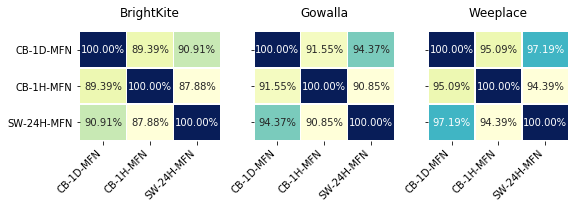

In [56]:
fig, axn = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(ttest_CCP[i], ax=ax, linewidths=.5, annot=True, fmt=".2%", cbar=False, cmap="YlGnBu"
#                 cbar=i == 0,
#                 vmin=0.77, vmax=1,
#                 cbar_ax=None if i else cbar_ax
               )
    ax.xaxis.set_label_position('bottom')
    ax.set_title(ds_list[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('fig/VIP_T_Test_CCP_MeetupNp3.pdf')

In [57]:
# CI computation

In [37]:
# Only for PI
lower = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_all_used.groupby(['Included', 'category',
                           'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [38]:
# Only for CCE
lower_CCE = df_all_used.groupby(['Included', 'category',
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper_CCE = df_all_used.groupby(['Included', 'category',
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid_CCE = df_all_used.groupby(['Included', 'category',
                           'dataset'])['CCE_alters_ratio'].mean().reset_index()

In [64]:
all_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), 
                   [mid, lower, upper, mid_CCE, lower_CCE, upper_CCE])
all_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper','mean_CCE', 'lower_CCE', 'upper_CCE']

In [65]:
# all_final.to_csv('final/150_all_category_CP.csv', index=False)
all_final.to_csv('final/150_all_category_MeetupNp.csv', index=False)
# all_final.to_csv('final/FreqNp_Rank/150_all_category_FreqNp.csv', index=False)

# All these MFNs and TFN (Global Jaccard Similarity)

In [34]:
import pickle
import matplotlib.pyplot as plt

In [47]:
# pickle_in = open("final/wp-150/wp_VIP_similarity_CP.pickle", "rb")
# wp_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/bk-150/bk_VIP_similarity_CP.pickle", "rb")
# bk_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/gws-150/gws_VIP_similarity_CP.pickle", "rb")
# gws_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

pickle_in = open("final/wp-150/wp_VIP_similarity_MeetupNp.pickle", "rb")
wp_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/bk-150/bk_VIP_similarity_MeetupNp.pickle", "rb")
bk_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/gws-150/gws_VIP_similarity_MeetupNp.pickle", "rb")
gws_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

# pickle_in = open("final/wp-150/wp_VIP_similarity_FreqNp.pickle", "rb")
# wp_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/bk-150/bk_VIP_similarity_FreqNp.pickle", "rb")
# bk_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/gws-150/gws_VIP_similarity_FreqNp.pickle", "rb")
# gws_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

In [48]:
df = [bk_vip_similarity, gws_vip_similarity, wp_vip_similarity]

In [37]:
datasets = ['BrightKite', 'Gowalla', 'Weeplace']

In [50]:
for i in range(3):
    df[i].drop(df[i].tail(1).index,inplace=True)
    df[i].drop(df[i].columns[[-1,]], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


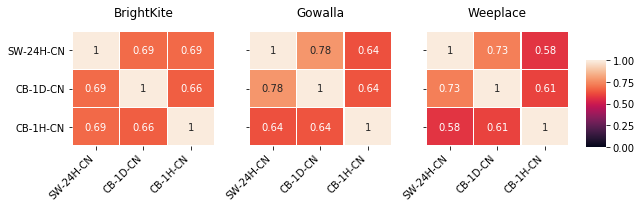

In [53]:
fig, axn = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(df[i], ax=ax, linewidths=.5, annot=True,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)
    ax.xaxis.set_label_position('bottom')
    ax.set_title(datasets[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
# plt.savefig('fig/VIP_similarity_FreqNp.pdf')
plt.savefig('fig/VIP_similarity_MeetupNp3.pdf')

# VIP LR

In [69]:
# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_CP.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_CP.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_CP.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_MeetupNp.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_MeetupNp.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_MeetupNp.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_FreqNp.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_FreqNp.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_FreqNp.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_cumulative_LR_MeetupNp.csv')
wp_vip_LR['dataset'] = 'Weeplace'

bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_cumulative_LR_MeetupNp.csv')
bk_vip_LR['dataset'] = 'BrightKite'

gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_cumulative_LR_MeetupNp.csv')
gw_vip_LR['dataset'] = 'Gowalla'

# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_cumulative_LR_FreqNp.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_cumulative_LR_FreqNp.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_cumulative_LR_FreqNp.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

In [70]:
vip_LR = pd.concat([wp_vip_LR, bk_vip_LR, gw_vip_LR])

In [107]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['USLR'].mean().reset_index()
vip_USLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_USLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_USLR['LR'] = 'USLR'

In [108]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['SLR'].mean().reset_index()

vip_SLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_SLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_SLR['LR'] = 'SLR'

In [109]:
vip_LR_final = pd.concat([vip_USLR, vip_SLR])

In [110]:
# vip_LR_final.to_csv('final/150_all_LR_CP.csv', index=False)
# vip_LR_final.to_csv('final/150_all_LR_MeetupNp.csv', index=False)
# vip_LR_final.to_csv('final/150_all_LR_FreqNp.csv', index=False)

vip_LR_final.to_csv('final/150_all_cumulative_LR_MeetupNp.csv', index=False)

# vip_LR_final.to_csv('final/150_all_cumulative_LR_FreqNp.csv', index=False)

In [73]:
two_side_t_test(vip_LR[vip_LR['category'].isin(['TFN', 'CB-1H-MFN'])], 'USLR')

([           CB-1H-MFN       TFN
  CB-1H-MFN   0.984848  0.893939
  TFN         0.893939  1.000000,
             CB-1H-MFN       TFN
  CB-1H-MFN   1.000000  0.922535
  TFN         0.922535  1.000000,
             CB-1H-MFN       TFN
  CB-1H-MFN   1.000000  0.950877
  TFN         0.950877  1.000000],
 ['BrightKite', 'Gowalla', 'Weeplace'])

In [74]:
wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_MeetupNp.csv')
wp_vip_LR['dataset'] = 'Weeplace'

bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_MeetupNp.csv')
bk_vip_LR['dataset'] = 'BrightKite'

gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_MeetupNp.csv')
gw_vip_LR['dataset'] = 'Gowalla'

vip_LR = pd.concat([wp_vip_LR, bk_vip_LR, gw_vip_LR])

In [75]:
two_side_t_test(vip_LR[vip_LR['category'].isin(['TFN', 'CB-1H-MFN'])], 'USLR')

([           CB-1H-MFN       TFN
  CB-1H-MFN   1.000000  0.984848
  TFN         0.984848  1.000000,
             CB-1H-MFN      TFN
  CB-1H-MFN    1.00000  0.93662
  TFN          0.93662  1.00000,
             CB-1H-MFN       TFN
  CB-1H-MFN   1.000000  0.985965
  TFN         0.985965  1.000000],
 ['BrightKite', 'Gowalla', 'Weeplace'])

# H-MFN vs TFN Cross validation

In [5]:
wp_vip_cv =  pd.read_csv('final/wp-150-cv/wp_join_vip10_CV_MeetupNp.csv')
wp_vip_cv['dataset'] = 'Weeplace'

bk_vip_cv = pd.read_csv('final/bk-150-cv/bk_join_vip10_CV_MeetupNp.csv')
bk_vip_cv['dataset'] = 'BrightKite'

gw_vip_cv = pd.read_csv('final/gws-150-cv/gws_join_vip10_CV_MeetupNp.csv')
gw_vip_cv['dataset'] = 'Gowalla'

In [6]:
vip_CV = pd.concat([wp_vip_cv, bk_vip_cv, gw_vip_cv])

In [117]:
vip_lower = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_CV.groupby(['Included', 'category', 'dataset'])['Pi_alters_ratio'].mean().reset_index()
vip_CV_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_CV_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']

In [118]:
# vip_CV_final.to_csv('final/150_all_CV_MeetupNp.csv', index=False)

# Statistical Test for OLDR and COLDR

## Test for CODLR

In [76]:
wp_vip_SLR =  pd.read_csv('final/wp-150/wp_VIP_cumulative_LR_MeetupNp.csv')
wp_vip_SLR['dataset'] = 'Weeplace'

bk_vip_SLR = pd.read_csv('final/bk-150/bk_VIP_cumulative_LR_MeetupNp.csv')
bk_vip_SLR['dataset'] = 'BrightKite'

gw_vip_SLR = pd.read_csv('final/gws-150/gws_VIP_cumulative_LR_MeetupNp.csv')
gw_vip_SLR['dataset'] = 'Gowalla'

vip_SLR = pd.concat([wp_vip_SLR, bk_vip_SLR, gw_vip_SLR])

In [78]:
vip_SLR

,Included,userid,userid_y,category,USLR,SLR,dataset
0,1,4sq-seoul,siegfrid,CB-1H-MFN,0.137931,0.354930,Weeplace
1,2,4sq-seoul,mrblues,CB-1H-MFN,0.155172,0.552113,Weeplace
2,3,4sq-seoul,onepiece-chopper,CB-1H-MFN,0.215517,0.884507,Weeplace
3,4,4sq-seoul,nikki5,CB-1H-MFN,0.241379,1.194366,Weeplace
4,5,4sq-seoul,jaehoon-choi,CB-1H-MFN,0.241379,1.430986,Weeplace
...,...,...,...,...,...,...,...
5675,6,10962,10094,TFN,0.391705,0.520000,Gowalla
5676,7,10962,10659,TFN,0.400922,0.571852,Gowalla
5677,8,10962,1791,TFN,0.410138,0.582222,Gowalla
5678,9,10962,10101,TFN,0.419355,0.616296,Gowalla


In [80]:
spearman_kendall_test(vip_SLR[vip_SLR['category'] != 'TFN'], 'USLR')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,dataset,category,SpN,SpP,Kn,Kp,total
0,BrightKite,CB-1D-MFN,66,1.000000,66,1.000000,66
1,BrightKite,CB-1H-MFN,65,0.984848,65,0.984848,66
2,BrightKite,SW-24H-MFN,65,0.984848,65,0.984848,66
3,Gowalla,CB-1D-MFN,142,1.000000,142,1.000000,142
4,Gowalla,CB-1H-MFN,142,1.000000,142,1.000000,142
5,Gowalla,SW-24H-MFN,142,1.000000,142,1.000000,142
6,Weeplace,CB-1D-MFN,285,1.000000,285,1.000000,285
7,Weeplace,CB-1H-MFN,285,1.000000,285,1.000000,285
8,Weeplace,SW-24H-MFN,285,1.000000,285,1.000000,285


In [44]:
ttest_CODLR, ds_list = two_side_t_test(vip_SLR[vip_SLR['category'] != 'TFN'], 'USLR')

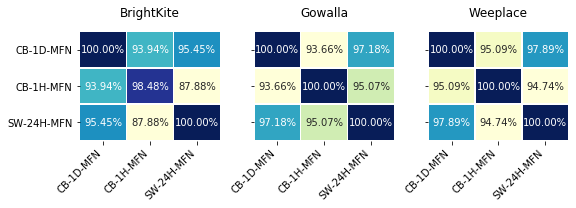

In [48]:
fig, axn = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(ttest_CODLR[i], ax=ax, linewidths=.5, annot=True, fmt=".2%", cbar=False, cmap="YlGnBu"
#                 cbar=i == 0,
#                 vmin=0.77, vmax=1,
#                 cbar_ax=None if i else cbar_ax
               )
    ax.xaxis.set_label_position('bottom')
    ax.set_title(ds_list[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('fig/VIP_T_Test_CODLR_MeetupNp3.pdf')

## T-test for ODLR

In [82]:
wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_MeetupNp.csv')
wp_vip_LR['dataset'] = 'Weeplace'

bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_MeetupNp.csv')
bk_vip_LR['dataset'] = 'BrightKite'

gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_MeetupNp.csv')
gw_vip_LR['dataset'] = 'Gowalla'

vip_LR = pd.concat([wp_vip_LR, bk_vip_LR, gw_vip_LR])

In [83]:
spearman_kendall_test(vip_LR[vip_LR['category'] != 'TFN'], 'USLR')

,dataset,category,SpN,SpP,Kn,Kp,total
0,BrightKite,CB-1D-MFN,0,0.000000,0,0.000000,66
1,BrightKite,CB-1H-MFN,2,0.030303,0,0.000000,66
2,BrightKite,SW-24H-MFN,1,0.015152,0,0.000000,66
3,Gowalla,CB-1D-MFN,0,0.000000,0,0.000000,142
4,Gowalla,CB-1H-MFN,0,0.000000,0,0.000000,142
5,Gowalla,SW-24H-MFN,0,0.000000,0,0.000000,142
6,Weeplace,CB-1D-MFN,0,0.000000,0,0.000000,285
7,Weeplace,CB-1H-MFN,1,0.003509,1,0.003509,285
8,Weeplace,SW-24H-MFN,0,0.000000,0,0.000000,285


In [46]:
ttest_ODLR, ds_list = two_side_t_test(vip_LR[vip_LR['category'] != 'TFN'], 'USLR')

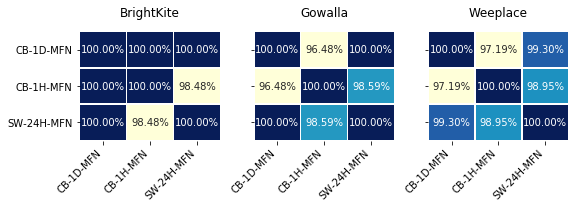

In [49]:
fig, axn = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(ttest_ODLR[i], ax=ax, linewidths=.5, annot=True, fmt=".2%", cbar=False, cmap="YlGnBu"
#                 cbar=i == 0,
#                 vmin=0.77, vmax=1,
#                 cbar_ax=None if i else cbar_ax
               )
    ax.xaxis.set_label_position('bottom')
    ax.set_title(ds_list[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('fig/VIP_T_Test_ODLR_MeetupNp3.pdf')